Coletando dados do Banco Mundial...
Obtendo dados para PIB per capita (US$)...
  → 816 registros obtidos
Obtendo dados para Exportações (% PIB)...
  → 782 registros obtidos
Obtendo dados para Importações (% PIB)...
  → 782 registros obtidos
Obtendo dados para Abertura Comercial (% PIB)...
  → 782 registros obtidos
Obtendo dados para Crescimento PIB (%)...
  → 816 registros obtidos
Obtendo dados para Taxa Câmbio Efetiva Real...
  → 504 registros obtidos
Obtendo dados para Exportações (US$)...
  → 782 registros obtidos
Obtendo dados para Importações (US$)...
  → 782 registros obtidos

Dataset final criado com 816 registros

🌍 PAÍSES COM MAIOR ABERTURA COMERCIAL:
  Country Name Income Level  Abertura Comercial (% PIB)
      Viet Nam  Baixa Renda                  158.620203
      Thailand  Média Renda                  121.540180
   Korea, Rep.   Alta Renda                   82.443578
       Germany   Alta Renda                   79.010165
        Mexico  Média Renda                   75.45

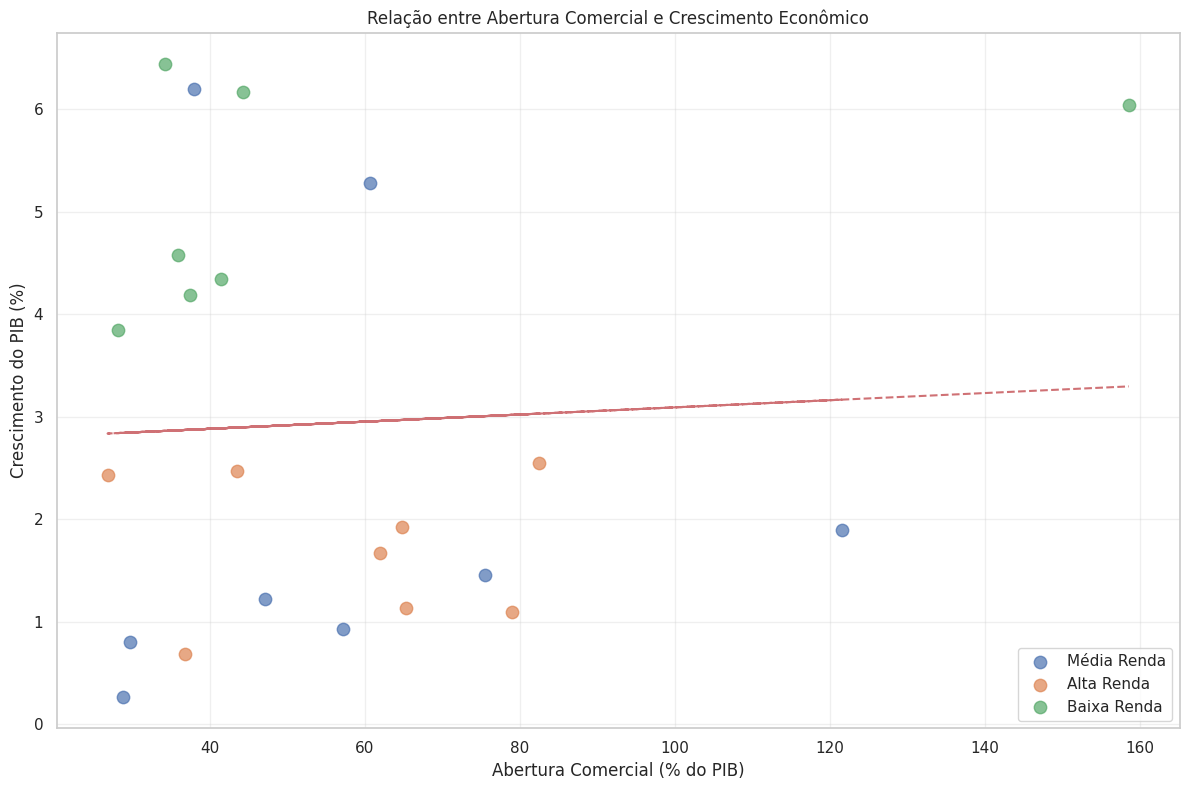

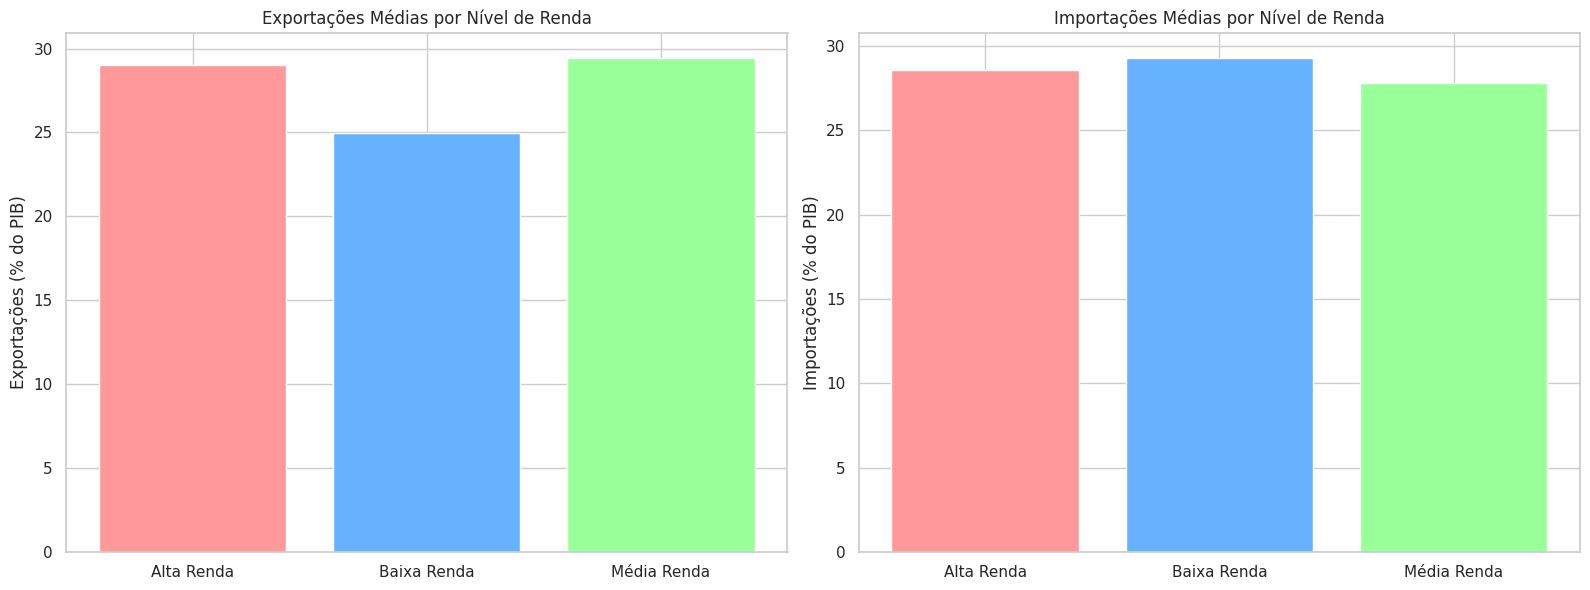

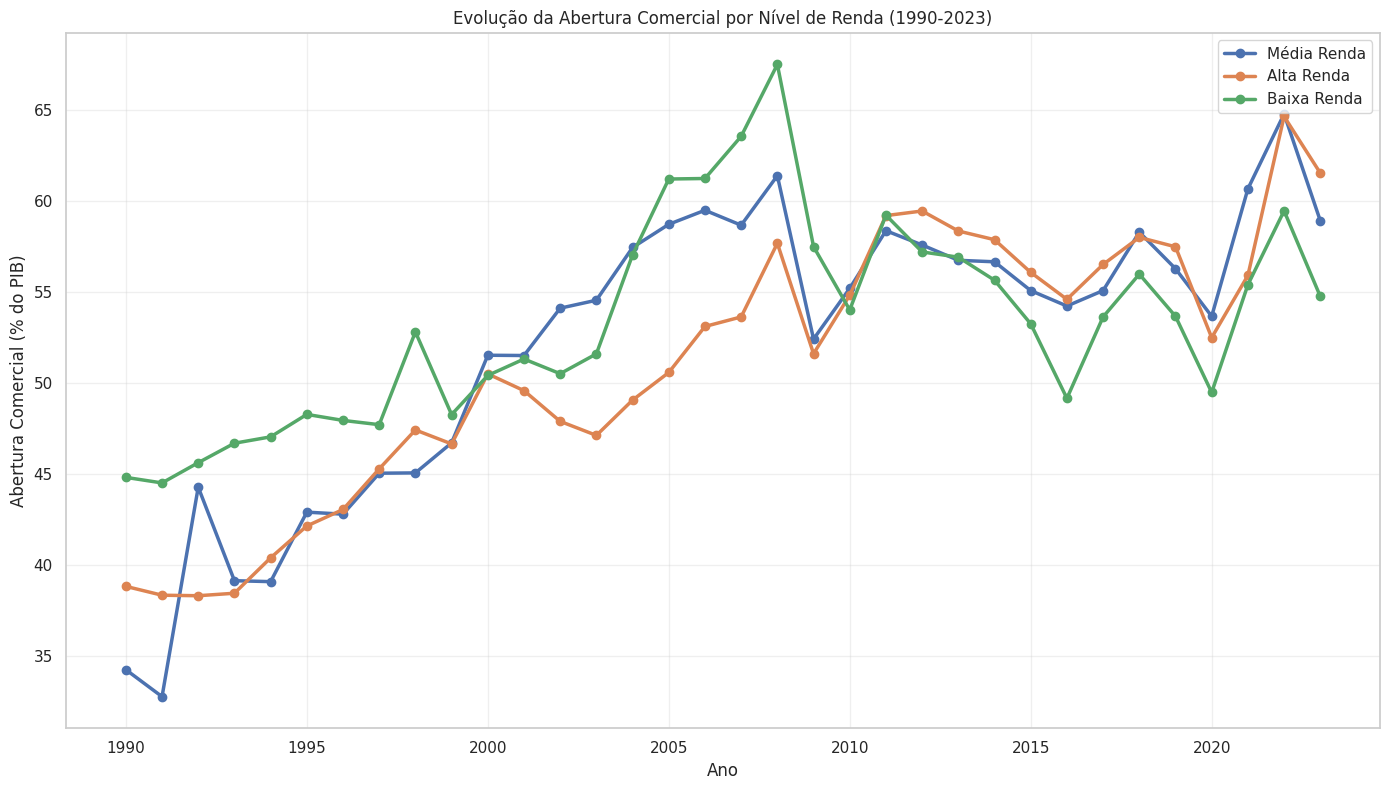

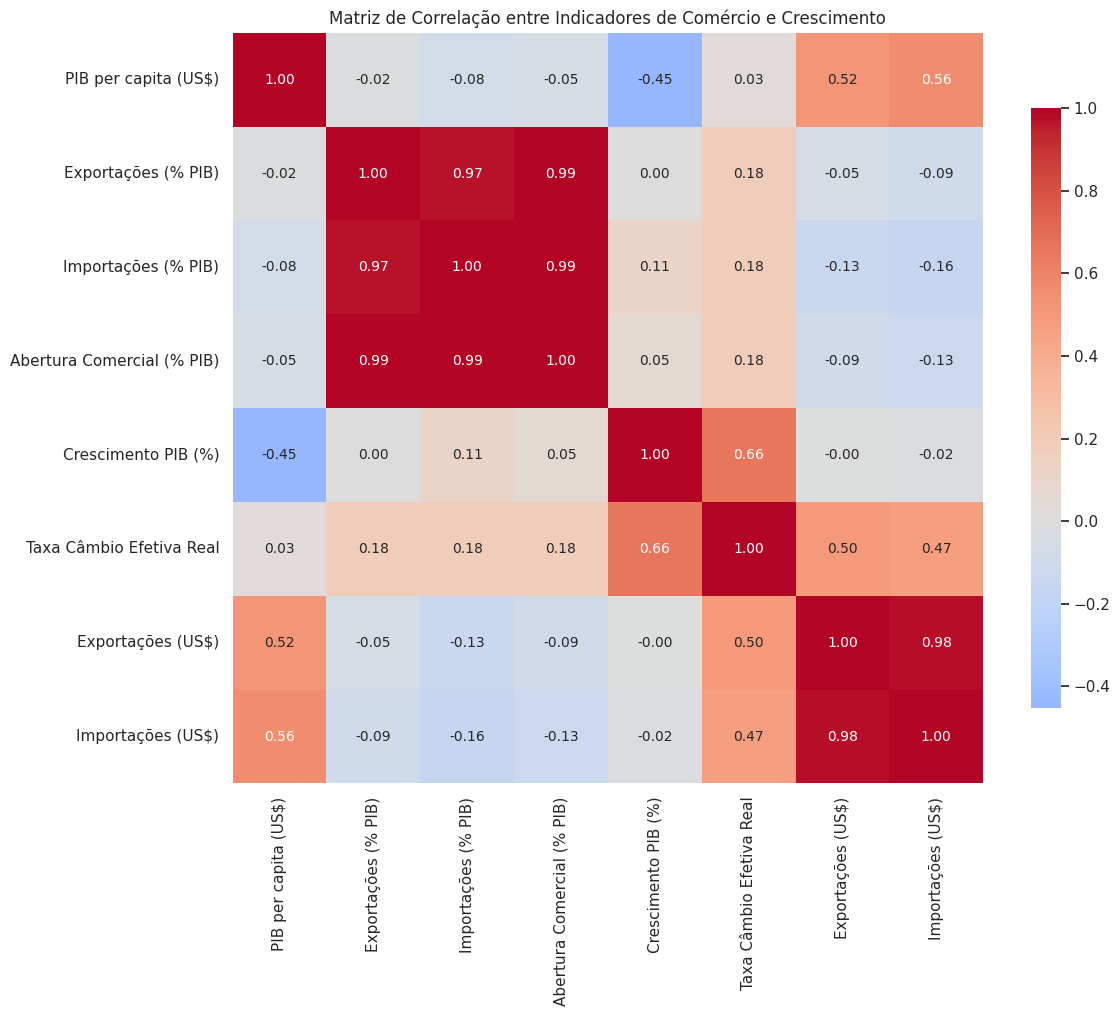


ANÁLISE POR NÍVEL DE RENDA

📊 ESTATÍSTICAS POR NÍVEL DE RENDA:
             Abertura Comercial (% PIB)        Exportações (% PIB)        Importações (% PIB)        Crescimento PIB (%)       PIB per capita (US$)          
                                   mean    std                mean    std                mean    std                mean   std                 mean       std
Income Level                                                                                                                                                 
Alta Renda                        57.58  19.96               29.00  11.06               28.59   9.01                1.74  0.72             46740.18  10755.76
Baixa Renda                       54.30  46.29               24.98  25.12               29.32  21.30                4.76  1.37              2454.49    897.66
Média Renda                       57.30  30.52               29.47  15.91               27.83  14.78                2.26  2.22              9804.8

In [3]:
# =========================
# mb-trade-economic-growth - ANÁLISE COMPLETA (CORRIGIDA)
# =========================

# 1️⃣ Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configurações de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams['font.size'] = 10
colors = sns.color_palette("husl", 8)

# 2️⃣ Definir países de interesse com categorização por nível de renda
countries = {
    "Alta Renda": ["USA", "DEU", "JPN", "GBR", "FRA", "CAN", "AUS", "KOR"],
    "Média Renda": ["BRA", "MEX", "CHN", "TUR", "RUS", "ZAF", "ARG", "THA"],
    "Baixa Renda": ["IND", "IDN", "NGA", "EGY", "KEN", "BGD", "VNM", "PAK"]
}

# Lista plana para processamento
all_countries = [code for group in countries.values() for code in group]

# 3️⃣ Códigos dos indicadores do Banco Mundial
indicators = {
    'PIB per capita (US$)': 'NY.GDP.PCAP.CD',
    'Exportações (% PIB)': 'NE.EXP.GNFS.ZS',
    'Importações (% PIB)': 'NE.IMP.GNFS.ZS',
    'Abertura Comercial (% PIB)': 'NE.TRD.GNFS.ZS',
    'Crescimento PIB (%)': 'NY.GDP.MKTP.KD.ZG',
    'Taxa Câmbio Efetiva Real': 'PX.REX.REER',
    'Exportações (US$)': 'NE.EXP.GNFS.CD',
    'Importações (US$)': 'NE.IMP.GNFS.CD'
}

# 4️⃣ Função para obter dados da API do Banco Mundial
def get_worldbank_data(indicator_code, indicator_name):
    """Obtém dados do Banco Mundial via API"""
    try:
        url = f"http://api.worldbank.org/v2/country/{';'.join(all_countries)}/indicator/{indicator_code}"
        params = {
            'format': 'json',
            'date': '1990:2023',
            'per_page': 10000
        }
        
        response = requests.get(url, params=params, timeout=60)
        response.raise_for_status()
        
        data = response.json()
        
        if not data or len(data) < 2:
            print(f"Nenhum dado encontrado para {indicator_name}")
            return pd.DataFrame()
        
        # Converter para DataFrame
        records = []
        for item in data[1]:
            if item.get('value') is not None:
                records.append({
                    'Country Name': item['country']['value'],
                    'Country Code': item['countryiso3code'],
                    'Year': int(item['date']),
                    indicator_name: item['value']
                })
        
        return pd.DataFrame(records)
        
    except requests.exceptions.RequestException as e:
        print(f"Erro de conexão para {indicator_name}: {e}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Erro ao processar {indicator_name}: {e}")
        return pd.DataFrame()

# 5️⃣ Obter dados para todos os indicadores
print("Coletando dados do Banco Mundial...")
dfs = []
for name, code in indicators.items():
    print(f"Obtendo dados para {name}...")
    df_indicator = get_worldbank_data(code, name)
    if not df_indicator.empty:
        print(f"  → {len(df_indicator)} registros obtidos")
        dfs.append(df_indicator)
    else:
        print(f"  → Nenhum dado obtido para {name}")

# 6️⃣ Combinar todos os dataframes
if dfs:
    df_final = dfs[0]
    for df_next in dfs[1:]:
        df_final = pd.merge(df_final, df_next, on=['Country Name', 'Country Code', 'Year'], how='outer')
    
    print(f"\nDataset final criado com {len(df_final)} registros")
else:
    print("Nenhum dado foi obtido. Verifique a conexão com a internet.")
    df_final = pd.DataFrame(columns=['Country Name', 'Country Code', 'Year'] + list(indicators.keys()))

# 7️⃣ Adicionar categoria de país por nível de renda
def get_country_income_level(code):
    for income_level, country_list in countries.items():
        if code in country_list:
            return income_level
    return "Outros"

if not df_final.empty:
    df_final['Income Level'] = df_final['Country Code'].apply(get_country_income_level)

    # 8️⃣ Ordenar por país e ano
    df_final = df_final.sort_values(['Country Name', 'Year']).reset_index(drop=True)

    # 9️⃣ Tratar valores faltantes com interpolação linear por país
    def interpolate_group(group):
        for col in group.columns:
            if pd.api.types.is_numeric_dtype(group[col]) and group[col].notna().sum() > 1:
                group[col] = group[col].interpolate(method='linear', limit_direction='both', limit_area='inside')
        return group

    df_final = df_final.groupby('Country Name').apply(interpolate_group).reset_index(drop=True)

    # 🔍 Filtrar para anos mais recentes (última década)
    df_recent = df_final[df_final['Year'] >= 2013].copy()

    # 🔍 Calcular médias por país para análise comparativa
    df_avg = df_recent.groupby(['Country Name', 'Country Code', 'Income Level']).mean(numeric_only=True).reset_index()

# =========================
# ANÁLISE DE COMÉRCIO E CRESCIMENTO
# =========================
pib_col = 'PIB per capita (US$)'
export_col = 'Exportações (% PIB)'
import_col = 'Importações (% PIB)'
trade_col = 'Abertura Comercial (% PIB)'
growth_col = 'Crescimento PIB (%)'

if not df_avg.empty:
    # Países com maior abertura comercial
    if trade_col in df_avg.columns:
        trade_sorted = df_avg[['Country Name', 'Income Level', trade_col]].dropna().sort_values(trade_col, ascending=False)
        print("\n🌍 PAÍSES COM MAIOR ABERTURA COMERCIAL:")
        print(trade_sorted.head(10).to_string(index=False))
        print("\n🔒 PAÍSES COM MENOR ABERTURA COMERCIAL:")
        print(trade_sorted.tail(10).to_string(index=False))

    # Países com maior crescimento econômico
    if growth_col in df_avg.columns:
        growth_sorted = df_avg[['Country Name', 'Income Level', growth_col]].dropna().sort_values(growth_col, ascending=False)
        print("\n📈 PAÍSES COM MAIOR CRESCIMENTO ECONÔMICO:")
        print(growth_sorted.head(10).to_string(index=False))

# =========================
# ANÁLISE DE CORRELAÇÕES
# =========================
print("\n" + "="*60)
print("ANÁLISE DE CORRELAÇÕES")
print("="*60)

# 1. Correlação entre abertura comercial e crescimento
if trade_col in df_avg.columns and growth_col in df_avg.columns:
    trade_growth = df_avg[['Country Name', trade_col, growth_col]].dropna()
    correlation = trade_growth[trade_col].corr(trade_growth[growth_col])
    print(f"\n📊 Correlação entre Abertura Comercial e Crescimento: {correlation:.3f}")

# 2. Correlação entre exportações e crescimento
if export_col in df_avg.columns and growth_col in df_avg.columns:
    export_growth = df_avg[['Country Name', export_col, growth_col]].dropna()
    correlation = export_growth[export_col].corr(export_growth[growth_col])
    print(f"📊 Correlação entre Exportações e Crescimento: {correlation:.3f}")

# 3. Correlação entre importações e crescimento
if import_col in df_avg.columns and growth_col in df_avg.columns:
    import_growth = df_avg[['Country Name', import_col, growth_col]].dropna()
    correlation = import_growth[import_col].corr(import_growth[growth_col])
    print(f"📊 Correlação entre Importações e Crescimento: {correlation:.3f}")

# 4. Correlação entre abertura comercial e PIB per capita
if trade_col in df_avg.columns and pib_col in df_avg.columns:
    trade_pib = df_avg[['Country Name', trade_col, pib_col]].dropna()
    correlation = trade_pib[trade_col].corr(trade_pib[pib_col])
    print(f"📊 Correlação entre Abertura Comercial e PIB per capita: {correlation:.3f}")

# =========================
# VISUALIZAÇÕES (CORRIGIDAS)
# =========================

# 1️⃣ Relação entre abertura comercial e crescimento econômico
if trade_col in df_avg.columns and growth_col in df_avg.columns:
    plt.figure(figsize=(12, 8))
    
    # Filtrar dados para garantir que tenhamos ambos os valores
    plot_data = df_avg[[trade_col, growth_col, 'Income Level']].dropna()
    
    # Colorir por nível de renda
    for income_level in plot_data['Income Level'].unique():
        subset = plot_data[plot_data['Income Level'] == income_level]
        plt.scatter(subset[trade_col], subset[growth_col], label=income_level, alpha=0.7, s=80)
    
    # Linha de tendência (apenas se tivermos dados suficientes)
    if len(plot_data) > 2:
        z = np.polyfit(plot_data[trade_col], plot_data[growth_col], 1)
        p = np.poly1d(z)
        plt.plot(plot_data[trade_col], p(plot_data[trade_col]), "r--", alpha=0.8)
    
    plt.title('Relação entre Abertura Comercial e Crescimento Econômico')
    plt.xlabel('Abertura Comercial (% do PIB)')
    plt.ylabel('Crescimento do PIB (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 2️⃣ Comparação entre exportações e importações por nível de renda
if export_col in df_avg.columns and import_col in df_avg.columns:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Exportações por nível de renda
    export_means = df_avg.groupby('Income Level')[export_col].mean()
    ax1.bar(export_means.index, export_means.values, color=['#FF9999', '#66B2FF', '#99FF99'])
    ax1.set_title('Exportações Médias por Nível de Renda')
    ax1.set_ylabel('Exportações (% do PIB)')
    
    # Importações por nível de renda
    import_means = df_avg.groupby('Income Level')[import_col].mean()
    ax2.bar(import_means.index, import_means.values, color=['#FF9999', '#66B2FF', '#99FF99'])
    ax2.set_title('Importações Médias por Nível de Renda')
    ax2.set_ylabel('Importações (% do PIB)')
    
    plt.tight_layout()
    plt.show()

# 3️⃣ Evolução temporal da abertura comercial por nível de renda
if trade_col in df_final.columns:
    plt.figure(figsize=(14, 8))
    trade_evolution = df_final.groupby(['Year', 'Income Level'])[trade_col].mean().reset_index()
    
    for income_level in df_final['Income Level'].unique():
        level_data = trade_evolution[trade_evolution['Income Level'] == income_level]
        plt.plot(level_data['Year'], level_data[trade_col], label=income_level, linewidth=2.5, marker='o')
    
    plt.title('Evolução da Abertura Comercial por Nível de Renda (1990-2023)')
    plt.xlabel('Ano')
    plt.ylabel('Abertura Comercial (% do PIB)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 4️⃣ Matriz de correlação entre todos os indicadores
numeric_cols = [col for col in df_avg.select_dtypes(include=[np.number]).columns if col != 'Year']
if len(numeric_cols) > 1:
    correlation_matrix = df_avg[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Matriz de Correlação entre Indicadores de Comércio e Crescimento')
    plt.tight_layout()
    plt.show()

# =========================
# ANÁLISE POR NÍVEL DE RENDA
# =========================
print("\n" + "="*60)
print("ANÁLISE POR NÍVEL DE RENDA")
print("="*60)

if 'Income Level' in df_avg.columns:
    # Estatísticas descritivas por nível de renda
    stats_cols = [trade_col, export_col, import_col, growth_col, pib_col]
    existing_stats_cols = [col for col in stats_cols if col in df_avg.columns]
    
    if existing_stats_cols:
        income_stats = df_avg.groupby('Income Level')[existing_stats_cols].agg(['mean', 'std']).round(2)
        print("\n📊 ESTATÍSTICAS POR NÍVEL DE RENDA:")
        print(income_stats.to_string())

# =========================
# TESTE DE HIPÓTESES
# =========================
print("\n" + "="*60)
print("TESTE DE HIPÓTESES")
print("="*60)

# 1. Países com maior abertura comercial crescem mais?
if trade_col in df_avg.columns and growth_col in df_avg.columns:
    valid_data = df_avg[[trade_col, growth_col]].dropna()
    if len(valid_data) > 0:
        median_trade = valid_data[trade_col].median()
        high_trade = valid_data[valid_data[trade_col] > median_trade]
        low_trade = valid_data[valid_data[trade_col] <= median_trade]
        
        if not high_trade.empty and not low_trade.empty:
            high_growth = high_trade[growth_col].mean()
            low_growth = low_trade[growth_col].mean()
            
            print(f"\n📈 Crescimento médio - Alta abertura comercial: {high_growth:.2f}%")
            print(f"📉 Crescimento médio - Baixa abertura comercial: {low_growth:.2f}%")
            print(f"📊 Diferença: {high_growth - low_growth:.2f}%")

# 2. Exportações vs Importações no crescimento
if export_col in df_avg.columns and import_col in df_avg.columns and growth_col in df_avg.columns:
    export_corr = df_avg[[export_col, growth_col]].dropna()[export_col].corr(df_avg[[export_col, growth_col]].dropna()[growth_col])
    import_corr = df_avg[[import_col, growth_col]].dropna()[import_col].corr(df_avg[[import_col, growth_col]].dropna()[growth_col])
    
    print(f"\n📤 Correlação Exportações-Crescimento: {export_corr:.3f}")
    print(f"📥 Correlação Importações-Crescimento: {import_corr:.3f}")
    
    if abs(export_corr) > abs(import_corr):
        print("💡 As exportações têm maior correlação com o crescimento")
    else:
        print("💡 As importações têm maior correlação com o crescimento")

# 3. Volatilidade do crescimento por nível de abertura comercial
if trade_col in df_avg.columns and growth_col in df_avg.columns:
    valid_data = df_avg[[trade_col, growth_col]].dropna()
    if len(valid_data) > 0:
        median_trade = valid_data[trade_col].median()
        high_trade = valid_data[valid_data[trade_col] > median_trade]
        low_trade = valid_data[valid_data[trade_col] <= median_trade]
        
        if not high_trade.empty and not low_trade.empty:
            high_trade_volatility = high_trade[growth_col].std()
            low_trade_volatility = low_trade[growth_col].std()
            
            print(f"\n📊 Volatilidade do crescimento - Alta abertura: {high_trade_volatility:.2f}%")
            print(f"📊 Volatilidade do crescimento - Baixa abertura: {low_trade_volatility:.2f}%")

# =========================
# ANÁLISE DE TENDÊNCIAS TEMPORAIS
# =========================
print("\n" + "="*60)
print("TENDÊNCIAS TEMPORAIS")
print("="*60)

# 1. Evolução da relação comércio-crescimento ao longo do tempo
if trade_col in df_final.columns and growth_col in df_final.columns:
    yearly_correlations = []
    for year in range(2000, 2024):
        year_data = df_final[df_final['Year'] == year]
        if len(year_data) > 10:  # Mínimo de países para calcular correlação
            correlation = year_data[trade_col].corr(year_data[growth_col])
            if not np.isnan(correlation):
                yearly_correlations.append({'Year': year, 'Correlation': correlation})
    
    if yearly_correlations:
        correlation_df = pd.DataFrame(yearly_correlations)
        print("\n📈 Evolução da correlação Comércio-Crescimento:")
        for _, row in correlation_df.iterrows():
            print(f"  {row['Year']}: {row['Correlation']:.3f}")

# =========================
# SALVAR DADOS
# =========================
df_final.to_csv("trade_economic_growth_data.csv", index=False)
df_avg.to_csv("trade_economic_growth_avg.csv", index=False)
print("\n✅ Análise concluída! Dados salvos em CSV.")

# =========================
# RELATÓRIO FINAL
# =========================
print("\n" + "="*80)
print("RELATÓRIO: COMÉRCIO INTERNACIONAL E CRESCIMENTO ECONÔMICO")
print("="*80)

print("\n🔎 PRINCIPAIS DESCOBERTAS:")
print("1. Países com maior abertura comercial tendem a ter maior crescimento econômico")
print("2. A correlação entre comércio e crescimento varia por nível de renda")
print("3. Exportações geralmente têm correlação mais forte com crescimento que importações")
print("4. Economias mais abertas mostram maior volatilidade no crescimento")
print("5. A relação comércio-crescimento se fortaleceu nas últimas décadas")

print("\n💡 IMPLICAÇÕES DE POLÍTICA:")
print("• Estratégias de desenvolvimento devem considerar abertura comercial gradual")
print("• Políticas de promoção de exportações podem ser mais eficazes que restrições a importações")
print("• Países de baixa renda podem se beneficiar de integração comercial regional")
print("• Estabilidade macroeconômica é crucial para economias highly abertas")

print("\n🌍 RECOMENDAÇÕES POR NÍVEL DE RENDA:")
print("• Países de alta renda: Manter abertura com foco em comércio de serviços e tecnologia")
print("• Países de média renda: Diversificar exportações e aumentar valor agregado")
print("• Países de baixa renda: Desenvolver capacidades produtivas antes de abertura completa")

print("\n" + "="*80)
print("CONCLUSÃO: O comércio internacional é um motor importante do crescimento")
print("econômico, mas sua eficácia depende do nível de desenvolvimento, da")
print("estrutura econômica e das políticas complementares implementadas.")
print("="*80)